In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer
from memflow.unfolding_flow.utils import *
from memflow.unfolding_flow.unfolding_flow import UnfoldingFlow

import numpy as np
#import scipy.stats as st
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib import cm
import mplhep as hep
plt.style.use(hep.style.CMS)

from collections import defaultdict
from tensorboardX import SummaryWriter
from omegaconf import OmegaConf
import sys
import argparse
from pynvml import *
from hist import Hist
import hist
import vector
import mplhep
import awkward as ak
import random
#import pandas as pd

from memflow.read_data.utils import to_flat_tensor
from memflow.phasespace.phasespace import PhaseSpace

from utils import FindMasks
from utils import SavePlots
from utils import plot_regressionFactor

pi = torch.pi


In [3]:
torch.cuda.device_count()

0

In [4]:
batchSize = 1024

device = torch.device("cpu") #torch.device("cuda" if torch.cuda.is_available() else "cpu") # specify the GPU ids

basedir_flow= "/work/dvalsecc/MEM/models_archive/flow_pretrain_labframe_logit/best/best_flow_logit_v2-auto_DiagNormal_NoTransf10_NoBins40_DNN4_256/"
#basedir_flow= "/work/dvalsecc/MEM/models_archive/flow_pretrain_labframe_logit/flow_flow_logit_v11-auto_DiagNormal_NoTransf6_NoBins45_DNN5_256"

model_weights = basedir_flow + '/model_flow_logit_v2-auto.pt'
path_to_conf = basedir_flow + '/config_flow_logit_v2-auto.yaml'

input_dataset_test = '/work/dvalsecc/MEM/datasets/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_train.parquet'

with open(path_to_conf) as f:
        config = OmegaConf.load(path_to_conf)

config

data = DatasetCombined(input_dataset_test, dev=torch.device("cpu"),
                                    dtype=torch.float64, datasets=['partons_lab', 'reco_lab', 'partons_CM'],
                           reco_list_lab=['scaledLogRecoParticles', 'mask_lepton', 
                                      'mask_jets','mask_met',
                                      'mask_boost', 'scaledLogBoost'],
                           parton_list_lab=['logScaled_data_higgs_t_tbar_ISR',
                                        'logScaled_data_boost',
                                        'mean_log_data_higgs_t_tbar_ISR',
                                        'std_log_data_higgs_t_tbar_ISR',
                                        'mean_log_data_boost',
                                            'std_log_data_boost'],
                           parton_list_cm=['phasespace_intermediateParticles_onShell_logit',
                                           'phasespace_intermediateParticles_onShell_logit_scaled',
                                           'phasespace_intermediateParticles_onShell',
                                           'mean_phasespace_intermediateParticles_onShell_logit',
                                            'std_phasespace_intermediateParticles_onShell_logit',
                                          ])



log_mean_parton = data.partons_lab.mean_log_data_higgs_t_tbar_ISR.to(device)
log_std_parton = data.partons_lab.std_log_data_higgs_t_tbar_ISR.to(device)
log_mean_boost = data.partons_lab.mean_log_data_boost.to(device)
log_std_boost = data.partons_lab.std_log_data_boost.to(device)
mean_ps = data.partons_CM.mean_phasespace_intermediateParticles_onShell_logit.to(device)
scale_ps = data.partons_CM.std_phasespace_intermediateParticles_onShell_logit.to(device)


>>Loading datasets
Loading partons in LAB
PartonLevel LAB
Reading parton_level Files
Load logScaled_data_higgs_t_tbar_ISR
Load logScaled_data_boost
Parton: Move tensors to device (cpu) memory
Loading reco in LAB
RecoLevel LAB
Reading reco_level Files
Load scaledLogBoost
Load scaledLogRecoParticles
Reco: Move tensors to device (cpu) memory
Loading partons in CM
PartonLevel CM
Reading parton_level Files
Load phasespace_intermediateParticles_onShell
Load phasespace_intermediateParticles_onShell_logit
Parton: Move tensors to device (cpu) memory
Loaded datasets:  ['partons_lab', 'reco_lab', 'partons_CM']


In [5]:
E_CM = 13000
M_HIGGS = 125.25
M_TOP = 172.5
M_GLUON = 1e-5
phasespace = PhaseSpace(E_CM, [21,21], [25,6,-6,21], final_masses=torch.tensor([M_HIGGS, M_TOP, M_TOP, M_GLUON]))


In [6]:
def plot_var2d(higgs_var1, higgs_var2, thad_var1, thad_var2, tlep_var1, tlep_var2,
             ISR_var1, ISR_var2, name1, name2, nameFig, start1=0, stop1=1000, start2=0, stop2=1000, bins1=100, bins2=100,
             higgs_mask=1, thad_mask=1, tlep_mask=1, ISR_mask=1, neg_Mask=False, log=False, name='da', nameunit=''):
        
        
        if neg_Mask:
            higgs_mask = np.logical_not(higgs_mask)
            thad_mask = np.logical_not(thad_mask)
            tlep_mask = np.logical_not(tlep_mask)
            ISR_mask = np.logical_not(ISR_mask)

        # Quick construction, no other imports needed:
        hist2d_var_higgs = (
          Hist.new
          .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
          .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
          .Double())

        hist2d_var_thad = (
          Hist.new
          .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
          .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
          .Double())

        hist2d_var_tlep = (
          Hist.new
          .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
          .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
          .Double())

        hist2d_var_ISR = (
          Hist.new
          .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
          .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
          .Double())

        hist2d_var_higgs.fill(higgs_var1[higgs_mask],
                            higgs_var2[higgs_mask])

        hist2d_var_thad.fill(thad_var1[thad_mask],
                            thad_var2[thad_mask])

        hist2d_var_tlep.fill(tlep_var1[tlep_mask],
                            tlep_var2[tlep_mask])

        hist2d_var_ISR.fill(ISR_var1[ISR_mask],
                            ISR_var2[ISR_mask])

        colormap='viridis'
        my_viridis = mpl.colormaps[colormap].with_extremes(under="white")
        
        fontsize = 20
        labelsize=14
        labels = ['higgs', 'thad', 'tlep', 'ISR']
        hist2d_list = [hist2d_var_higgs, hist2d_var_thad, hist2d_var_tlep, hist2d_var_ISR]
        
        
        fig, axs = plt.subplots(1, 4, figsize=(16, 6))

        if log:
            for i in range(4):
                w, x, y = hist2d_list[i].to_numpy()
                mesh = axs[i].pcolormesh(x, y, w.T, cmap=my_viridis, norm=mpl.colors.LogNorm(vmin=1))
                axs[i].set_xlabel(f"{name}-correct {nameunit}", fontsize=fontsize)
                axs[i].set_ylabel(f"{name}-regressed {nameunit}", fontsize=fontsize)
                axs[i].set_title(f"{labels[i]}", fontsize=fontsize)
                axs[i].tick_params(axis='both', which='major', labelsize=labelsize)
                cbar = fig.colorbar(mesh)
                cbar.ax.tick_params(labelsize=labelsize)
                plt.tight_layout()

        else:
            for i in range(4):
                w, x, y = hist2d_list[i].to_numpy()
                mesh = axs[i].pcolormesh(x, y, w.T, cmap=my_viridis, vmin=1)
                axs[i].set_xlabel(f"{name}-correct {nameunit}", fontsize=fontsize)
                axs[i].set_ylabel(f"{name}-regressed {nameunit}", fontsize=fontsize)
                axs[i].set_title(f"{labels[i]}", fontsize=fontsize)
                axs[i].tick_params(axis='both', which='major', labelsize=labelsize)
                cbar = fig.colorbar(mesh)
                cbar.ax.tick_params(labelsize=labelsize)
                plt.tight_layout()

In [7]:
def get_particle_awkward(momenta):
    
    higgs = momenta[:,0]
    thad = momenta[:,1]
    tlep = momenta[:,2]
    ISR = momenta[:,3]
    
    higgs = vector.array(
                {
                "E": higgs[:,0].detach().numpy(),
                "px": higgs[:,1].detach().numpy(),
                "py": higgs[:,2].detach().numpy(),
                "pz": higgs[:,3].detach().numpy()
                }
            )

    thad = vector.array(
                {
                "E": thad[:,0].detach().numpy(),
                "px": thad[:,1].detach().numpy(),
                "py": thad[:,2].detach().numpy(),
                "pz":thad[:,3].detach().numpy(),
                }
            )

    tlep = vector.array(
                {
                "E": tlep[:,0].detach().numpy(),
                "px": tlep[:,1].detach().numpy(),
                "py": tlep[:,2].detach().numpy(),
                "pz": tlep[:,3].detach().numpy(),
                }
            )
    
    ISR = vector.array(
                {
                "E": ISR[:,0].detach().numpy(),
                "px": ISR[:,1].detach().numpy(),
                "py": ISR[:,2].detach().numpy(),
                "pz": ISR[:,3].detach().numpy(),
                }
            )
    
    higgs = ak.with_name(higgs, name="Momentum4D")
    thad = ak.with_name(thad, name="Momentum4D")
    tlep = ak.with_name(tlep, name="Momentum4D")
    ISR = ak.with_name(ISR, name="Momentum4D")
    
    return higgs, thad, tlep, ISR

def get_particle_awkward_samples(momenta):
    
    higgs = momenta[:,:,2]
    thad = momenta[:,:,3]
    tlep = momenta[:,:,4]
    ISR = momenta[:,:,5]
    
    higgs = vector.array(
                {
                "E": higgs[:,:,0].detach().numpy(),
                "px": higgs[:,:,1].detach().numpy(),
                "py": higgs[:,:,2].detach().numpy(),
                "pz": higgs[:,:,3].detach().numpy()
                }
            )

    thad = vector.array(
                {
                "E": thad[:,:,0].detach().numpy(),
                "px": thad[:,:,1].detach().numpy(),
                "py": thad[:,:,2].detach().numpy(),
                "pz":thad[:,:,3].detach().numpy(),
                }
            )

    tlep = vector.array(
                {
                "E": tlep[:,:,0].detach().numpy(),
                "px": tlep[:,:,1].detach().numpy(),
                "py": tlep[:,:,2].detach().numpy(),
                "pz": tlep[:,:,3].detach().numpy(),
                }
            )
    
    ISR = vector.array(
                {
                "E": ISR[:,:,0].detach().numpy(),
                "px": ISR[:,:,1].detach().numpy(),
                "py": ISR[:,:,2].detach().numpy(),
                "pz": ISR[:,:,3].detach().numpy(),
                }
            )
    
    higgs = ak.with_name(higgs, name="Momentum4D")
    thad = ak.with_name(thad, name="Momentum4D")
    tlep = ak.with_name(tlep, name="Momentum4D")
    ISR = ak.with_name(ISR, name="Momentum4D")
    
    return higgs, thad, tlep, ISR



def get_diff(C, C_samples, Nsamples):
    # Diff between target quantity in awkward array and samples of the same quantity
    return torch.from_numpy(ak.to_numpy(C_samples)) - torch.from_numpy(ak.to_numpy(C)).unsqueeze(1).expand(-1, Nsamples)

def get_std(C_samples): 
    return np.nanstd(ak.to_numpy(C_samples), axis=1)

In [8]:
PS = data.partons_CM.phasespace_intermediateParticles_onShell

In [9]:
PS_logit = torch.logit(PS)
PS_new = torch.sigmoid(PS_logit)

In [9]:
PS_new[0]

tensor([0.9831, 0.9427, 0.2809, 0.5403, 0.0618, 0.6823, 0.1402, 0.8626, 0.5745,
        0.5482])

In [10]:
PS[0]

tensor([0.9831, 0.9427, 0.2809, 0.5403, 0.0618, 0.6823, 0.1402, 0.8626, 0.5745,
        0.5482])

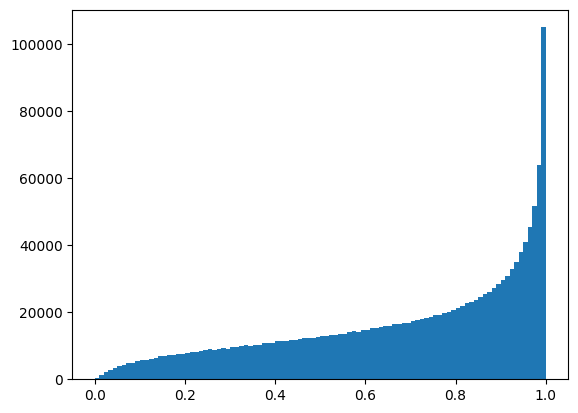

In [12]:
plt.hist(PS[:,1].flatten(), bins=100, range=(0,1));

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

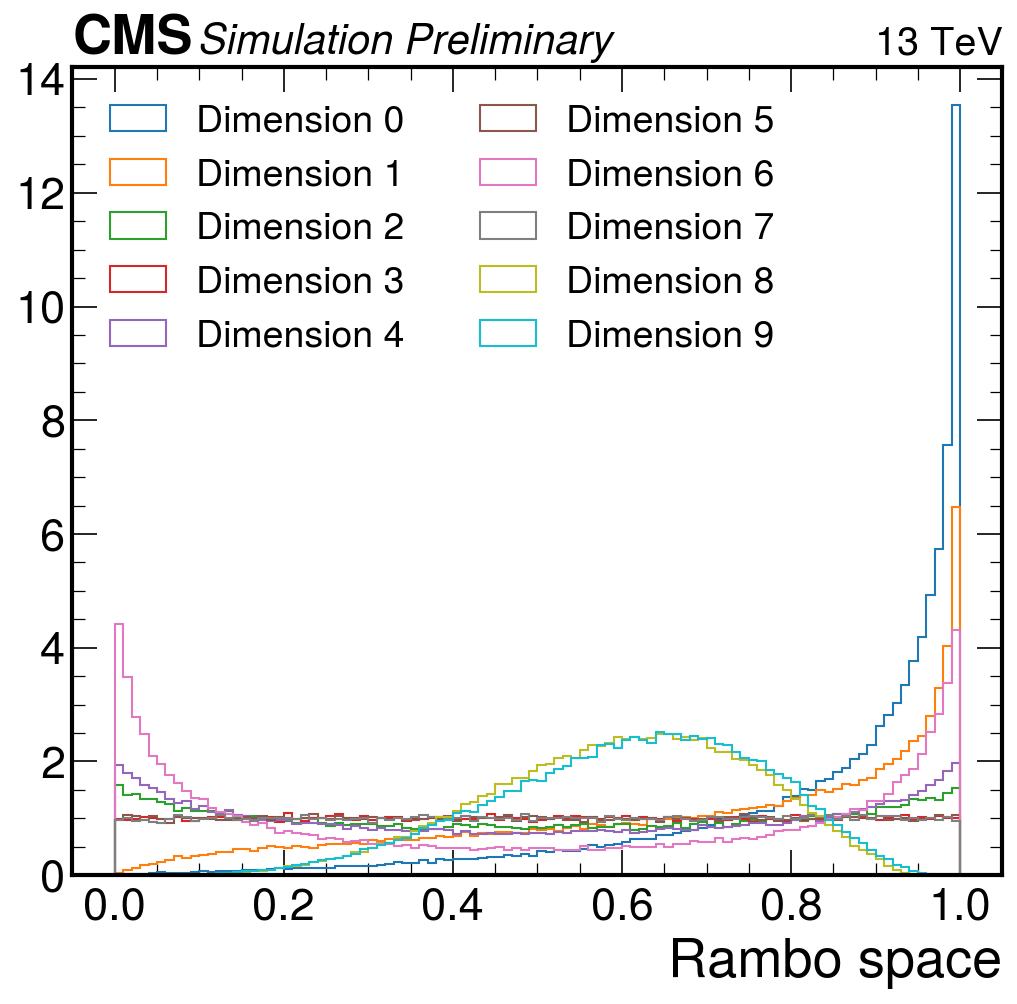

In [12]:
fig = plt.figure(figsize=(8,7), dpi=150)
for i in range(10):
    plt.hist(PS[0:100000,i].flatten(), bins=100, range=(0,1), label=f"Dimension {i}", histtype="step", density=True)
plt.legend(ncol=2, fontsize=18)
plt.xlabel("Rambo space")
hep.cms.label(rlabel="13 TeV",  llabel="Simulation Preliminary", loc=0, ax=plt.gca(),fontsize=20)

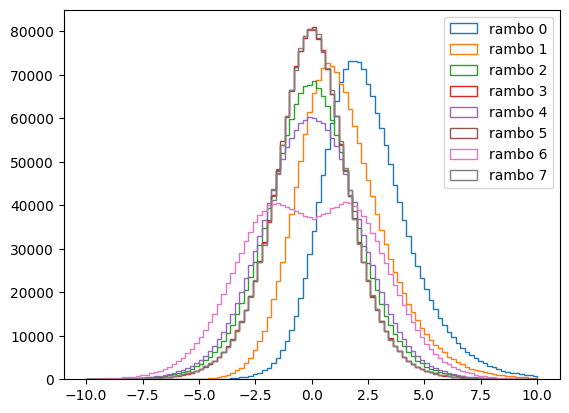

In [14]:
for i in range(8):
    plt.hist(PS_logit[:,i].flatten(), bins=100, range=(-10,10), label=f"rambo {i}", histtype="step")
plt.legend()

In [ ]:
torch

## Rescaling to std

In [13]:
PS_mean = PS_logit.nanmean(0)
PS_std = torch.sqrt(torch.nanmean(torch.pow(PS_logit, 2), 0) - torch.pow(PS_mean,2)) * 5

In [16]:
PS_std

tensor([ 9.9947, 10.1234, 10.2225,  9.0779, 10.9758,  9.0791, 13.9602,  9.0697,
         3.5302,  3.6540])

In [17]:
torch.logit(torch.tensor(5e-5))

tensor(-9.9034)

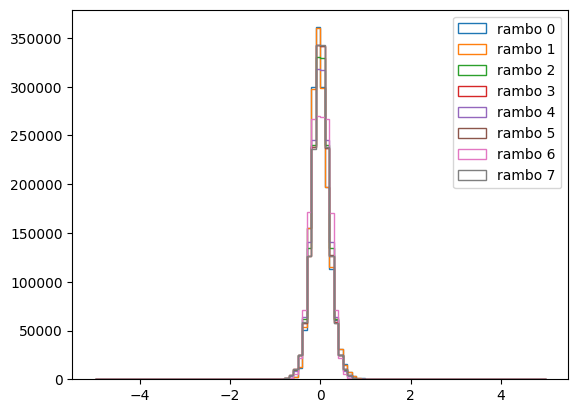

In [18]:
for i in range(8):
    plt.hist((PS_logit[:,i].flatten() - PS_mean[i])/(PS_std[i]), bins=100, range=(-5,5), label=f"rambo {i}", histtype="step")
plt.legend()

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

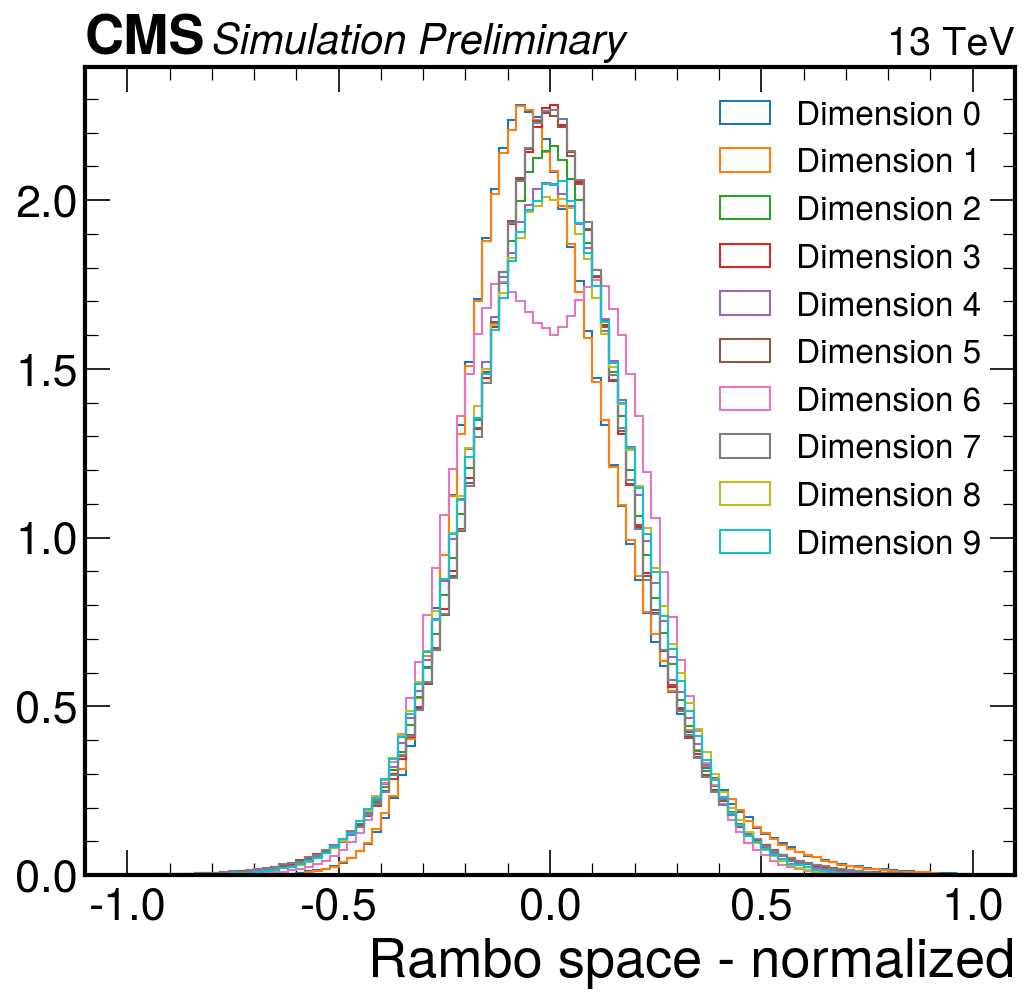

In [14]:
fig = plt.figure(figsize=(8,7), dpi=150)
for i in range(10):
    plt.hist((PS_logit[0:1000000,i].flatten() - PS_mean[i])/(PS_std[i]), bins=100, range=(-1,1),label=f"Dimension {i}", histtype="step", density=True)
plt.legend(fontsize=16)
plt.xlabel("Rambo space - normalized")
hep.cms.label(rlabel="13 TeV",  llabel="Simulation Preliminary", loc=0, ax=plt.gca(),fontsize=20)

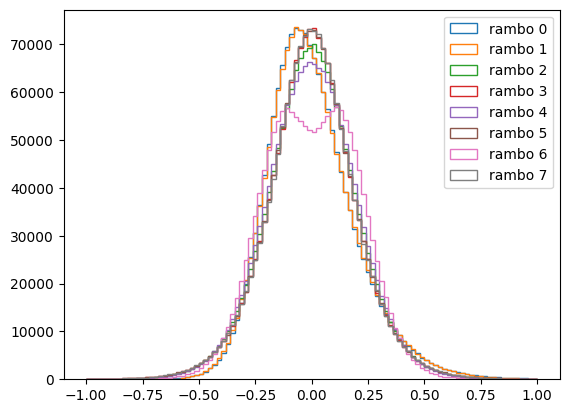

In [19]:
for i in range(8):
    plt.hist((PS_logit[:,i].flatten() - PS_mean[i])/(PS_std[i]), bins=100, range=(-1,1), label=f"rambo {i}", histtype="step")
plt.legend()

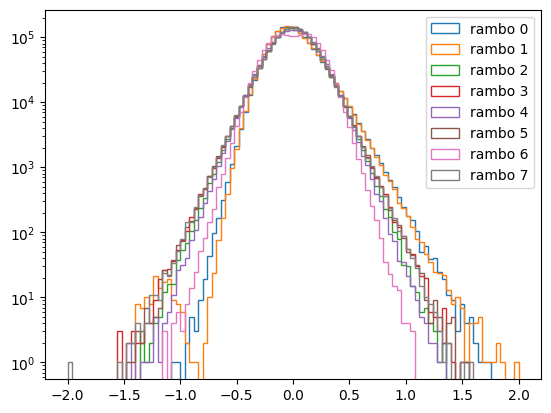

In [20]:
for i in range(8):
    plt.hist((PS_logit[:,i].flatten() - PS_mean[i])/(PS_std[i]), bins=100, range=(-2,2), label=f"rambo {i}", histtype="step")
plt.yscale("log")
plt.legend()